In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Read the data
demographic_data = pd.read_csv('/Users/minu/Desktop/test_heroku/Component 04/Backend/Dataset/demographic_data_dataset.csv')
defect_data = pd.read_csv('/Users/minu/Desktop/test_heroku/Component 04/Backend/Dataset/updated_worker_defect_details.csv')

# Convert Date columns to datetime
demographic_data['Joining_Date'] = pd.to_datetime(demographic_data['Joining_Date'], infer_datetime_format=True)
defect_data['Date'] = pd.to_datetime(defect_data['Date'], infer_datetime_format=True)

# Combine datasets on Worker_ID
combined_data = pd.merge(defect_data, demographic_data, on='Worker_ID')

# Calculate experience in days
combined_data['Experience'] = (combined_data['Date'] - combined_data['Joining_Date']).dt.days

# Drop unnecessary columns
fields_to_drop = ['Name', 'Joining_Date']
combined_data.drop(columns=fields_to_drop, inplace=True)

# Define categorical features for one-hot encoding
categorical_features = ['Gender', 'Skill_Level', 'Shift']
numerical_features = ['Age', 'Production_Volume', 'Experience']

# Ensure that all columns are present
missing_columns = [col for col in categorical_features + numerical_features if col not in combined_data.columns]
if missing_columns:
    raise ValueError(f"The following columns are missing in the combined dataset: {missing_columns}")

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

# Separate features and target variables
X = combined_data.drop(columns=['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4', 'defect_count', 'count', 'Worker_ID', 'Date'])
y = combined_data[['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4']]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/144865289.py:21: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  demographic_data['Joining_Date'] = pd.to_datetime(demographic_data['Joining_Date'], infer_datetime_format=True)
/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/144865289.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  demographic_data['Joining_Date'] = pd.to_datetime(demographic_data['Joining_Date'], infer_datetime_format=True)
/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/144865289.py:22: UserWarning: The argument 'infer_datetime_format' is deprecated and will be rem

In [4]:
# Define multiple models
models = {
    'RandomForest': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    'GradientBoosting': MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    'LinearRegression': MultiOutputRegressor(LinearRegression()),
    'SupportVector': MultiOutputRegressor(SVR())
}

# Evaluate each model using cross-validation
results = {}
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = -cv_scores.mean()  # Negate because cross_val_score uses negative MSE
    print(f"{model_name}: Mean CV MSE = {-cv_scores.mean()}")
print()

# Select the best model
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

print(f"Best model: {best_model_name} with Mean CV MSE = {results[best_model_name]}")
print()

# Train the best model on the full training data
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model and print MSE for each defect type
mse_values = mean_squared_error(y_test, y_pred, multioutput='raw_values')
defect_types = ['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4']

for defect_type, mse in zip(defect_types, mse_values):
    print(f"Mean Squared Error for {defect_type}: {mse}")

# Overall MSE
overall_mse = mean_squared_error(y_test, y_pred)
print(f"Overall Mean Squared Error: {overall_mse}")

# Function to get feature names after preprocessing
def get_feature_names(preprocessor, numerical_features, categorical_features):
    feature_names = numerical_features
    ohe_categories = preprocessor.transformers_[0][1].categories_
    cat_names = []
    for i, cat in enumerate(categorical_features):
        cat_names.extend([f"{cat}_{ohe_categories[i][j]}" for j in range(len(ohe_categories[i]))])
    feature_names.extend(cat_names)
    return feature_names

# Get the feature names
feature_names = get_feature_names(preprocessor, numerical_features, categorical_features)

RandomForest: Mean CV MSE = 6.913667452380953
GradientBoosting: Mean CV MSE = 7.518078092328734
LinearRegression: Mean CV MSE = 4.972604323072917
SupportVector: Mean CV MSE = 5.422002784556483

Best model: LinearRegression with Mean CV MSE = 4.972604323072917

Mean Squared Error for Run_Off_D1: 5.000910758316218
Mean Squared Error for Open_Seam_D2: 3.281276540349336
Mean Squared Error for SPI_Errors_D3: 4.778603083204815
Mean Squared Error for High_Low_D4: 5.5279410378289695
Overall Mean Squared Error: 4.647182854924835


In [5]:
# Plot feature importances for each defect type (for tree-based models)
if hasattr(best_model, 'estimators_') and hasattr(best_model.estimators_[0], 'feature_importances_'):
    for i, defect_type in enumerate(defect_types):
        importances = pipeline.named_steps['regressor'].estimators_[i].feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Plot the feature importances for each defect type
        plt.figure(figsize=(10, 6))
        plt.title(f"Feature Importances for {defect_type}")
        plt.bar(range(len(importances)), importances[indices], align='center', color='orange')
        plt.xticks(range(len(importances)), [feature_names[j] for j in indices], rotation=90)
        plt.xlim([-1, len(importances)])
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.show()

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/1735367613.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


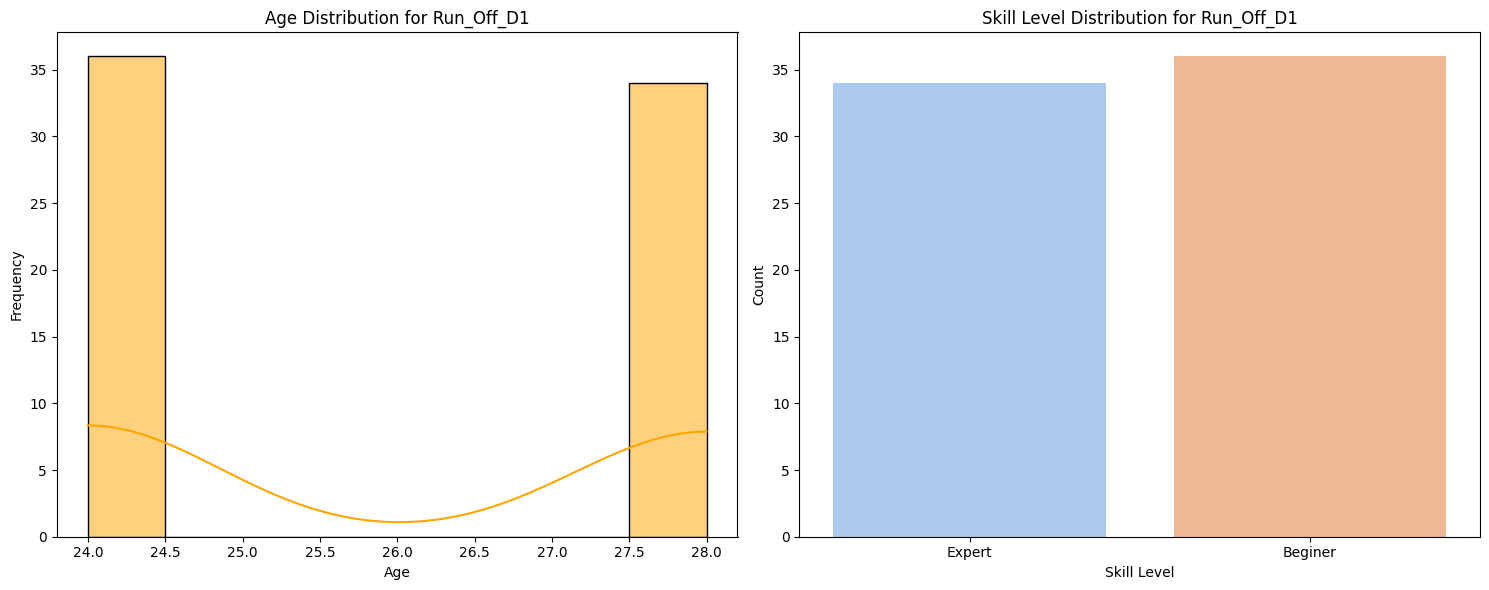

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/1735367613.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


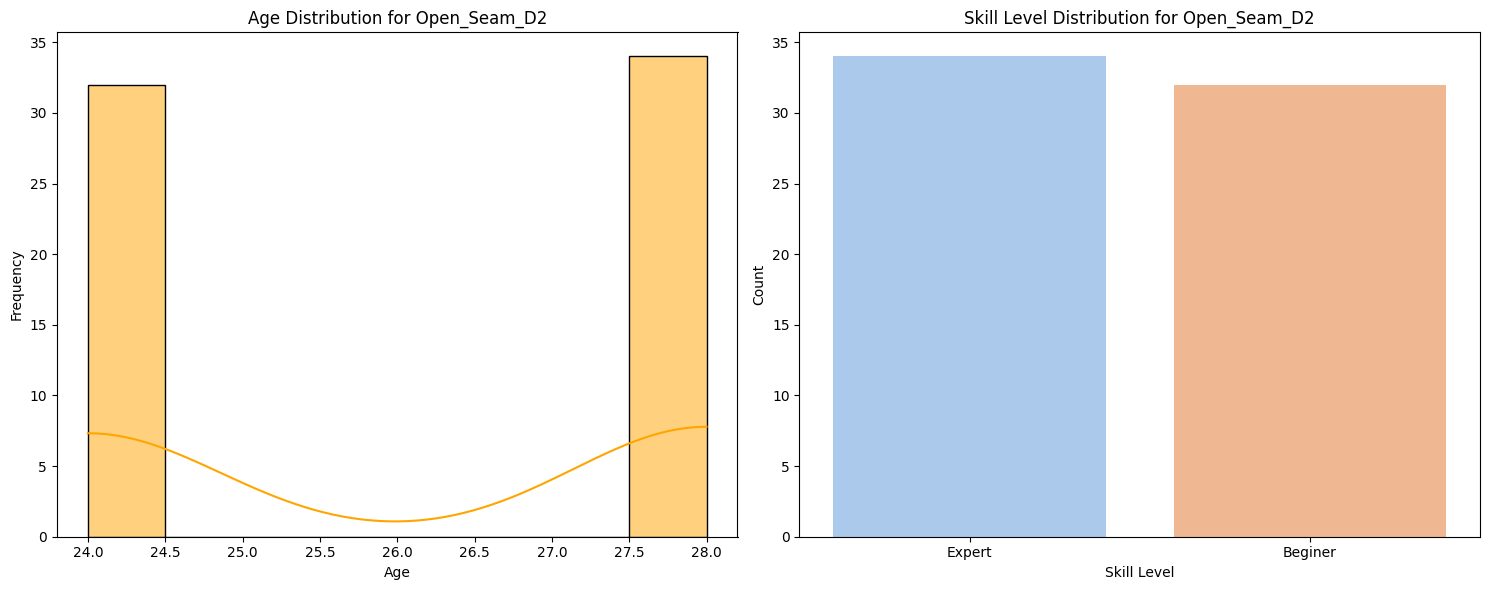

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/1735367613.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


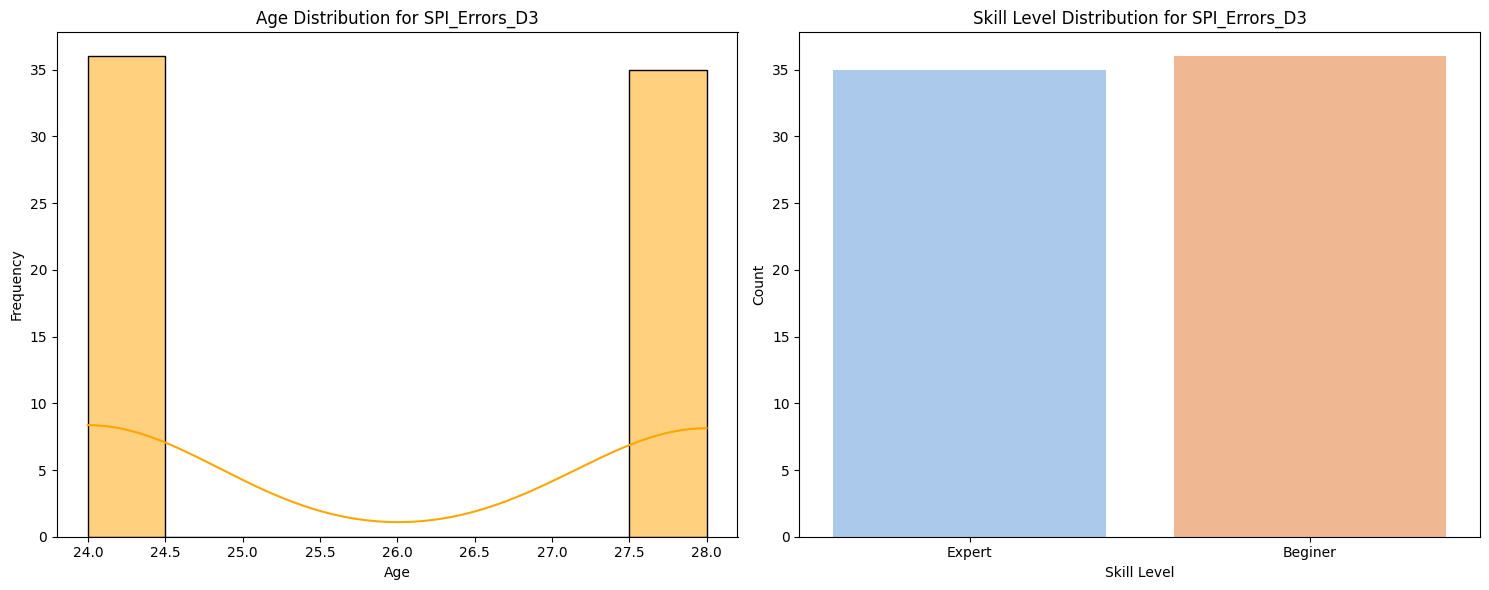

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/1735367613.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


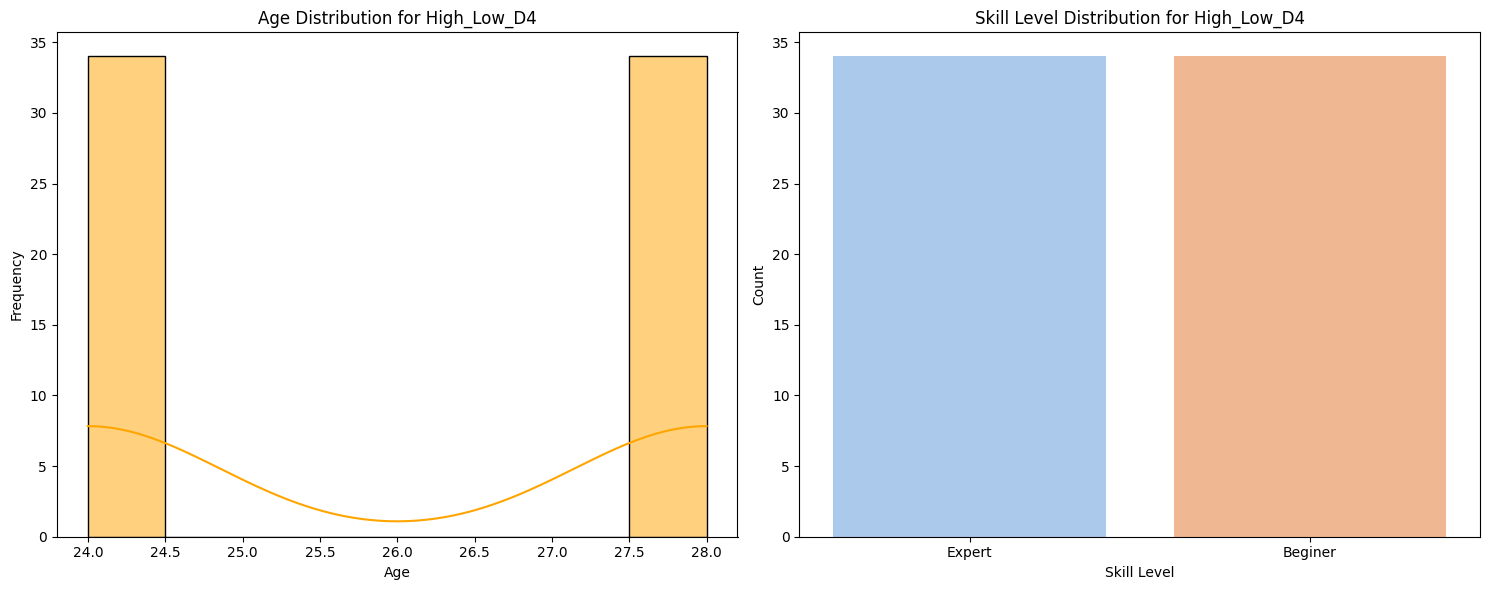

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/1735367613.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


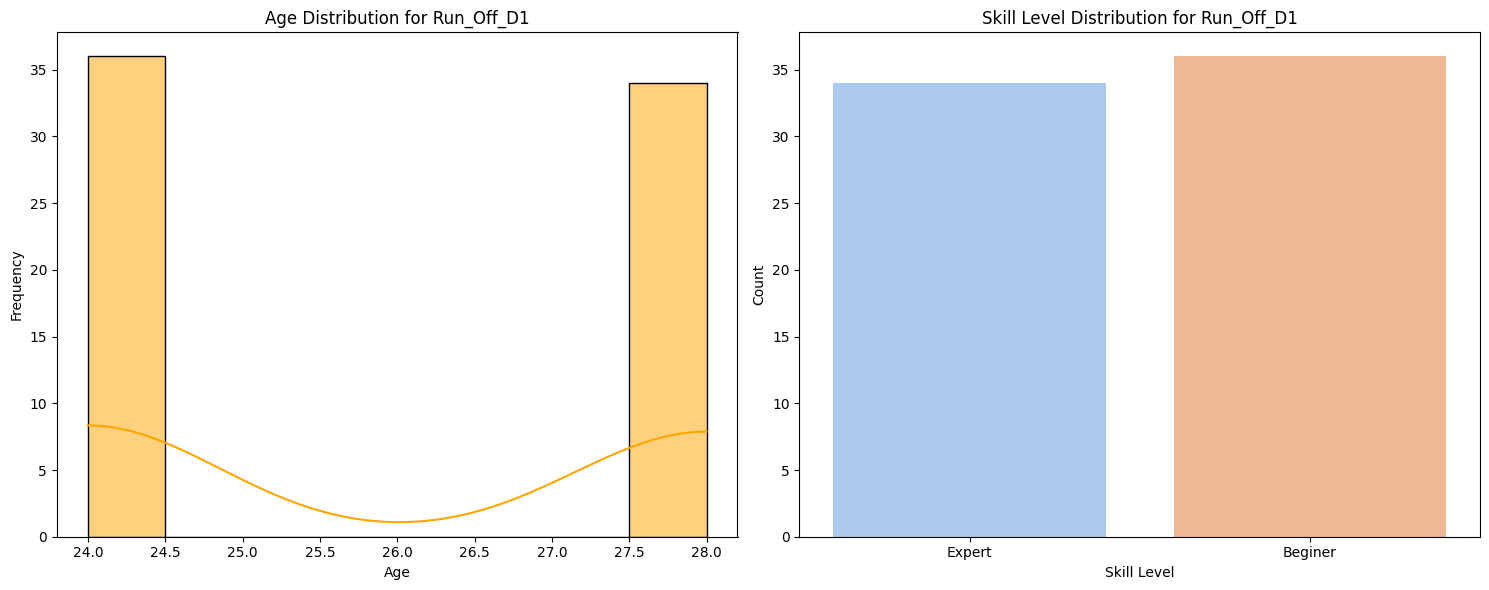

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/1735367613.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


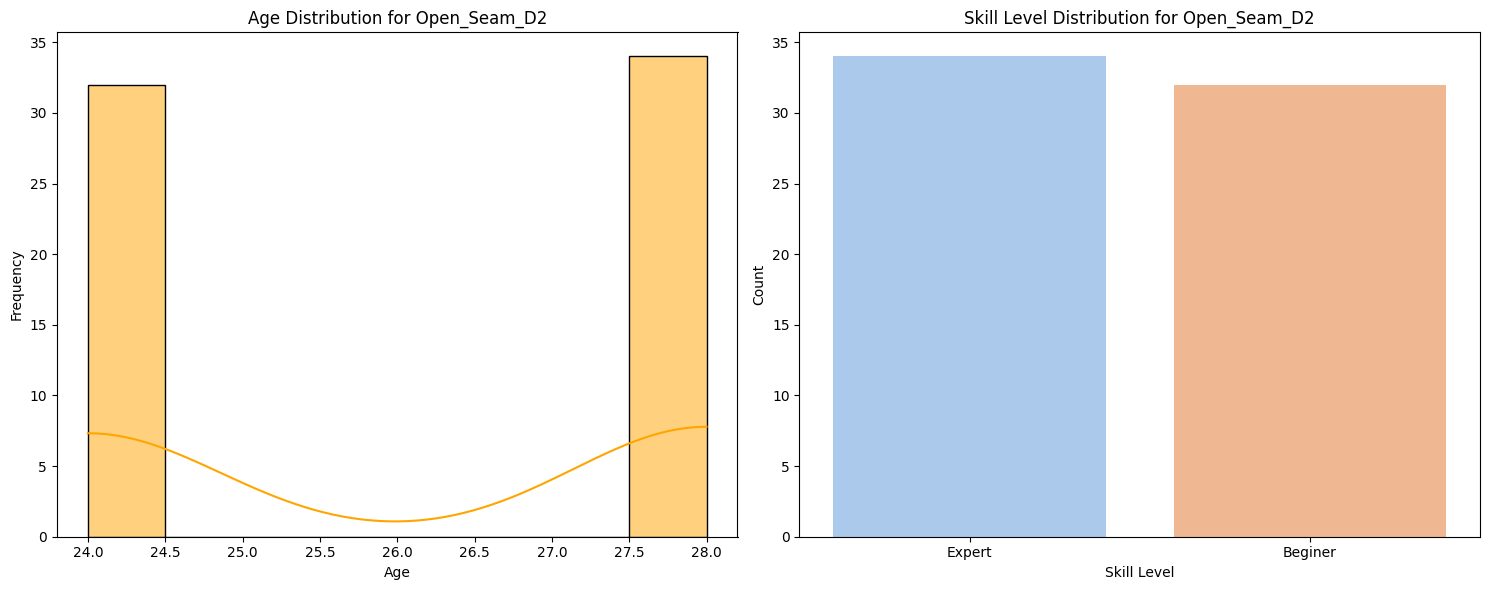

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/1735367613.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


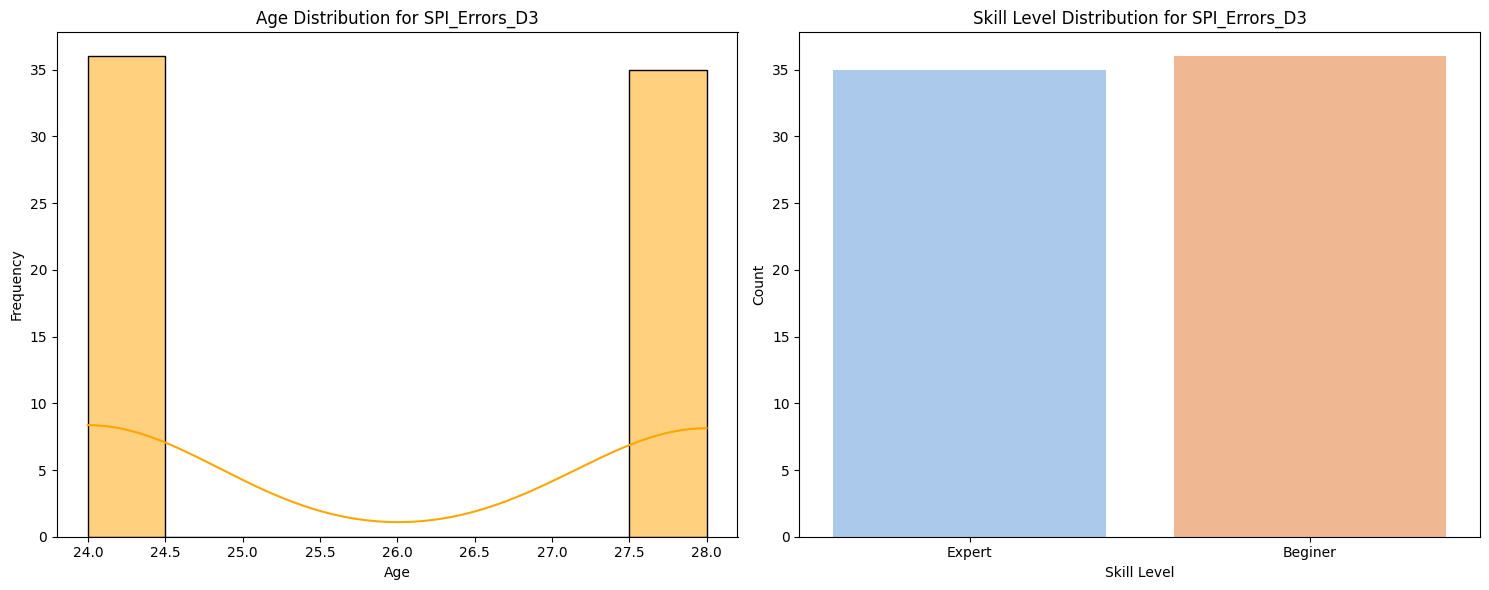

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/1735367613.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


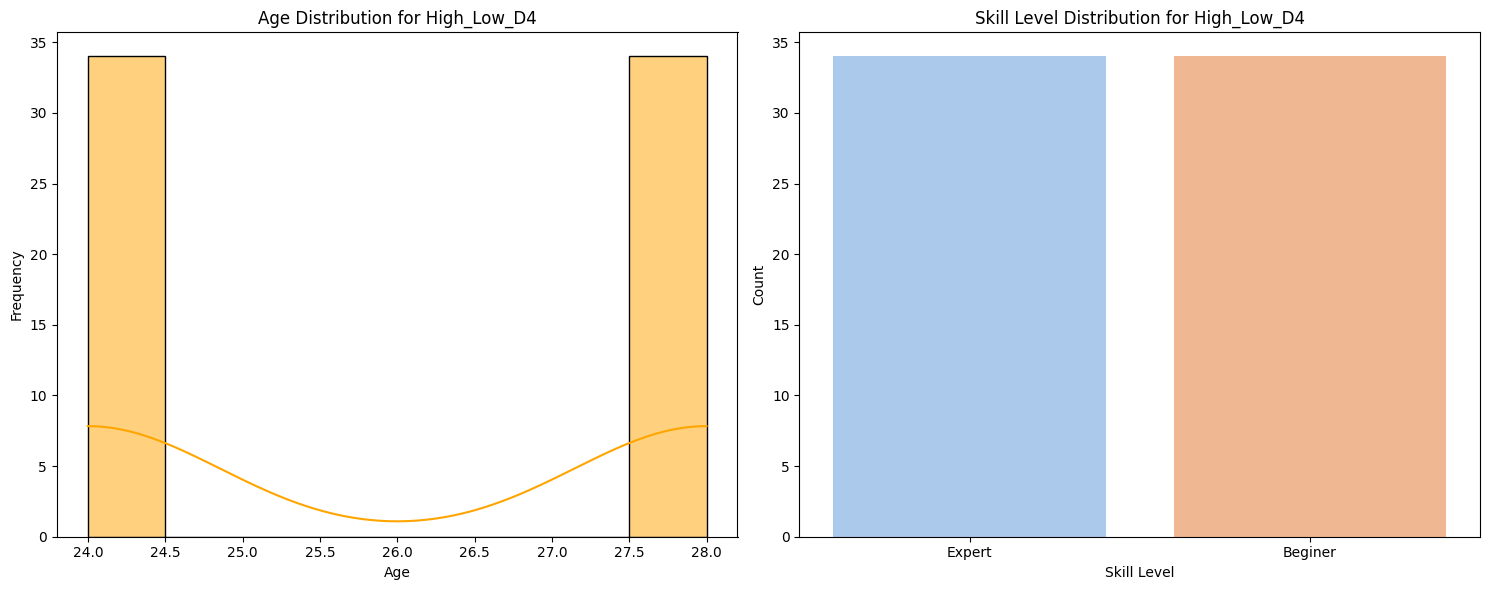

In [13]:
# Demographic Analysis for Age and Skill Level
def analyze_demographics(data, demographic_feature):
    for defect_type in defect_types:
        subset = data[data[defect_type] > 0]  # Filter rows where the defect type count is greater than 0
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
        
        # Age Distribution
        sns.histplot(subset['Age'], ax=axes[0], kde=True, color='orange')
        axes[0].set_title(f'Age Distribution for {defect_type}')
        axes[0].set_xlabel('Age')
        axes[0].set_ylabel('Frequency')
        
        # Skill Level Distribution
        sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')
        axes[1].set_title(f'Skill Level Distribution for {defect_type}')
        axes[1].set_xlabel('Skill Level')
        axes[1].set_ylabel('Count')
        
        plt.tight_layout()
        plt.show()

# Analyze the effect of Age and Skill Level on each defect type
analyze_demographics(combined_data, 'Age')
analyze_demographics(combined_data, 'Skill_Level')

# Function to perform demographic analysis for all workers
def demographic_analysis_all():
    plt.figure(figsize=(12, 6))
    sns.histplot(demographic_data['Age'], kde=True, color='blue')
    plt.title('Age Distribution for All Workers')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.countplot(x=demographic_data['Skill_Level'], palette='viridis')
    plt.title('Skill Level Distribution for All Workers')
    plt.xlabel('Skill Level')
    plt.ylabel('Count')
    plt.show()

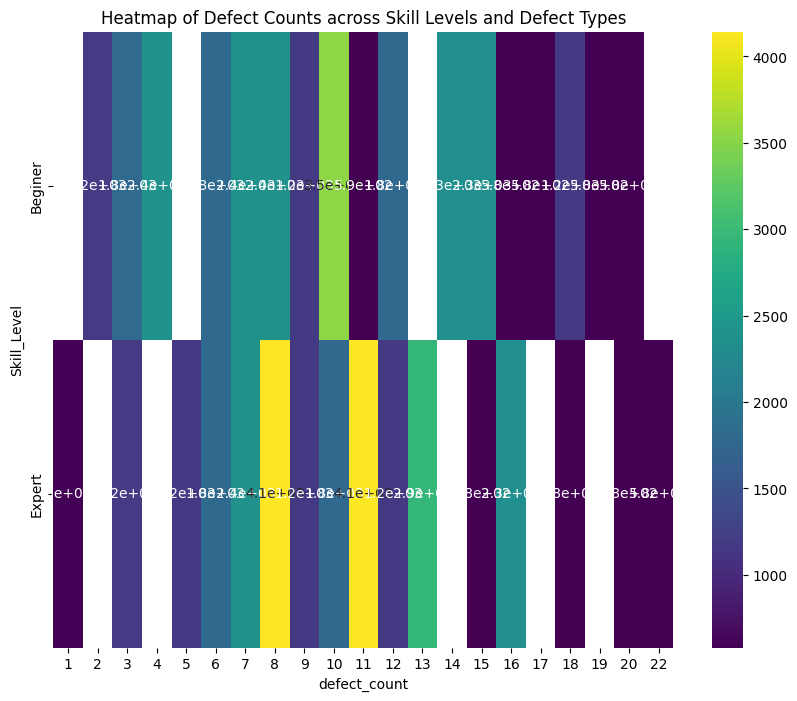

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/38409863.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=combined_data, x='Skill_Level', y='count', ci=None, palette='viridis')
/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/38409863.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=combined_data, x='Skill_Level', y='count', ci=None, palette='viridis')


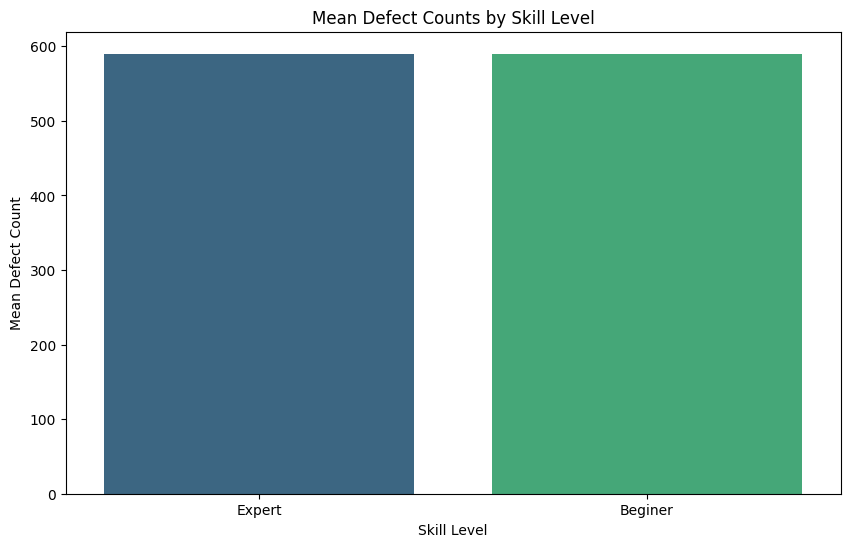

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/38409863.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=combined_data, x='Gender', y='count', ci=None, palette='viridis')
/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/38409863.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=combined_data, x='Gender', y='count', ci=None, palette='viridis')


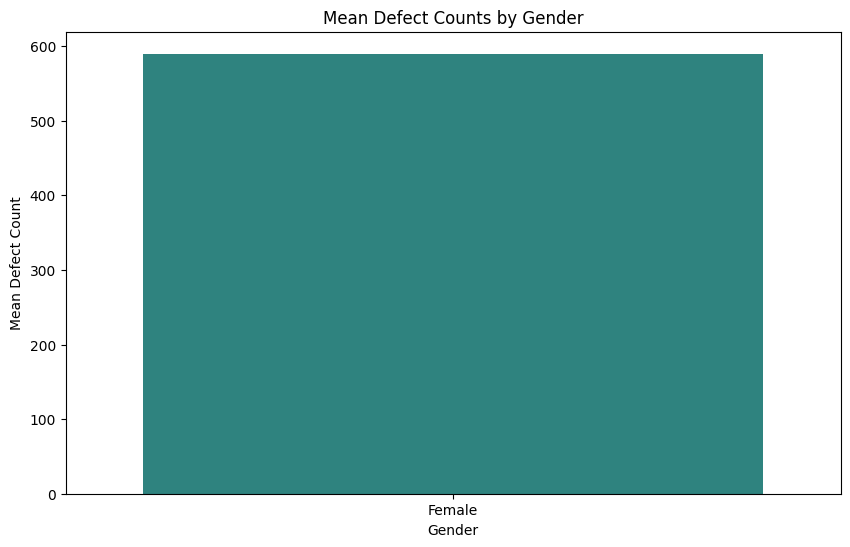

In [7]:
# Heatmap of defect counts across skill levels and defect types
pivot_table = combined_data.pivot_table(index='Skill_Level', columns='defect_count', values='count', aggfunc='sum')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Heatmap of Defect Counts across Skill Levels and Defect Types')
plt.show()

# Bar plot for mean defect counts by Skill Level
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_data, x='Skill_Level', y='count', ci=None, palette='viridis')
plt.title('Mean Defect Counts by Skill Level')
plt.xlabel('Skill Level')
plt.ylabel('Mean Defect Count')
plt.show()

# Bar plot for mean defect counts by Gender
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_data, x='Gender', y='count', ci=None, palette='viridis')
plt.title('Mean Defect Counts by Gender')
plt.xlabel('Gender')
plt.ylabel('Mean Defect Count')
plt.show()

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/3598995893.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x='defect_count', y='Age', palette='viridis')


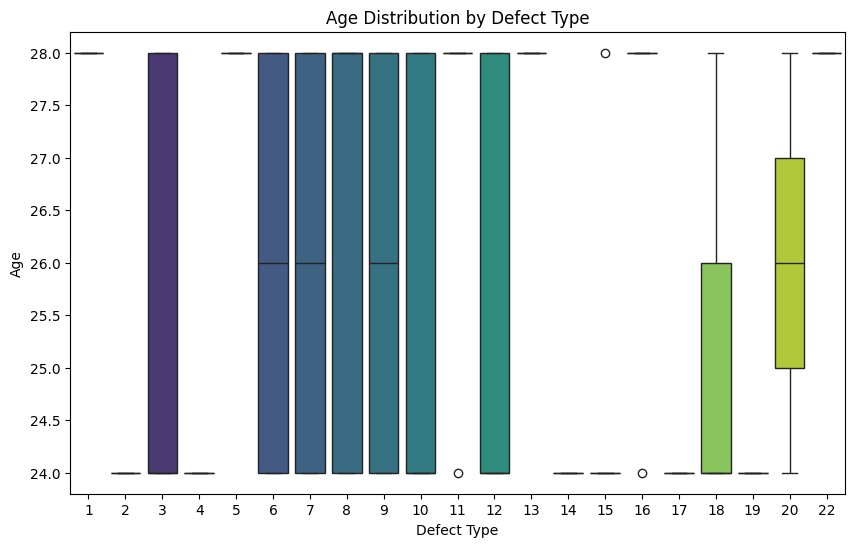

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/3598995893.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x='defect_count', y='Production_Volume', palette='viridis')


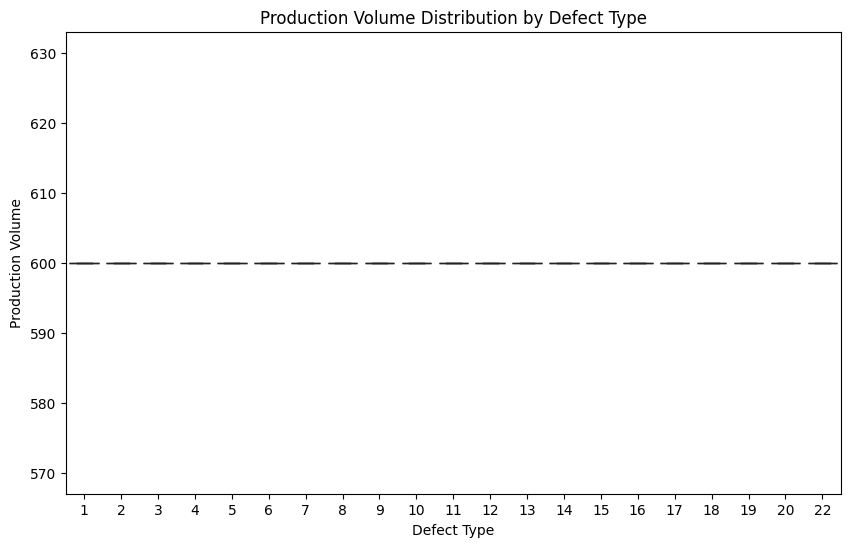

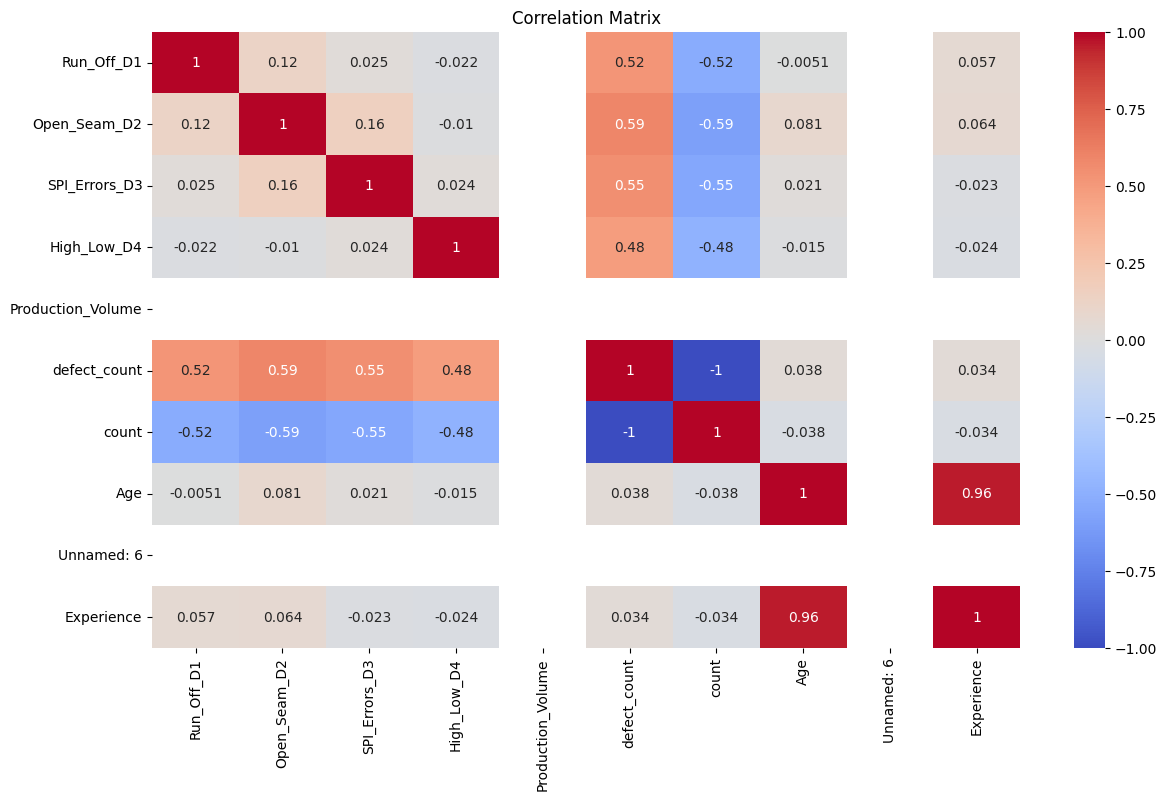

In [8]:
# Box plot for Age distribution by defect type
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data, x='defect_count', y='Age', palette='viridis')
plt.title('Age Distribution by Defect Type')
plt.xlabel('Defect Type')
plt.ylabel('Age')
plt.show()

# Box plot for Production Volume distribution by defect type
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data, x='defect_count', y='Production_Volume', palette='viridis')
plt.title('Production Volume Distribution by Defect Type')
plt.xlabel('Defect Type')
plt.ylabel('Production Volume')
plt.show()

# Correlation Matrix
numeric_columns = combined_data.select_dtypes(include=[np.number]).columns
correlation_matrix = combined_data[numeric_columns].corr()
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

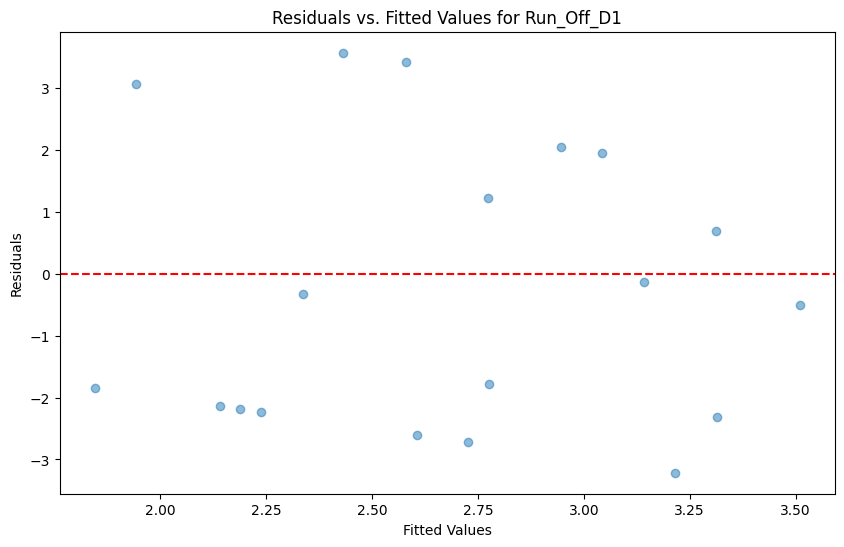

<Figure size 1000x600 with 0 Axes>

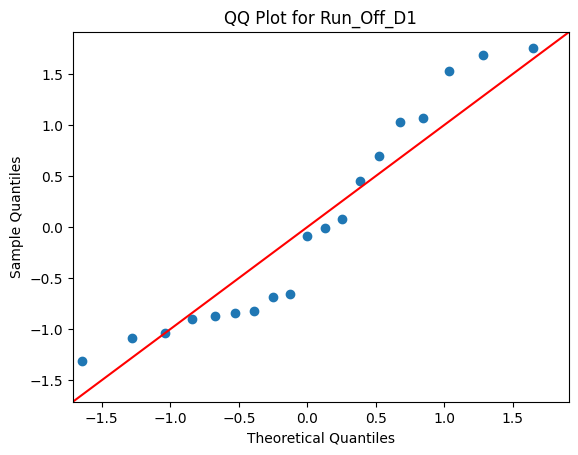

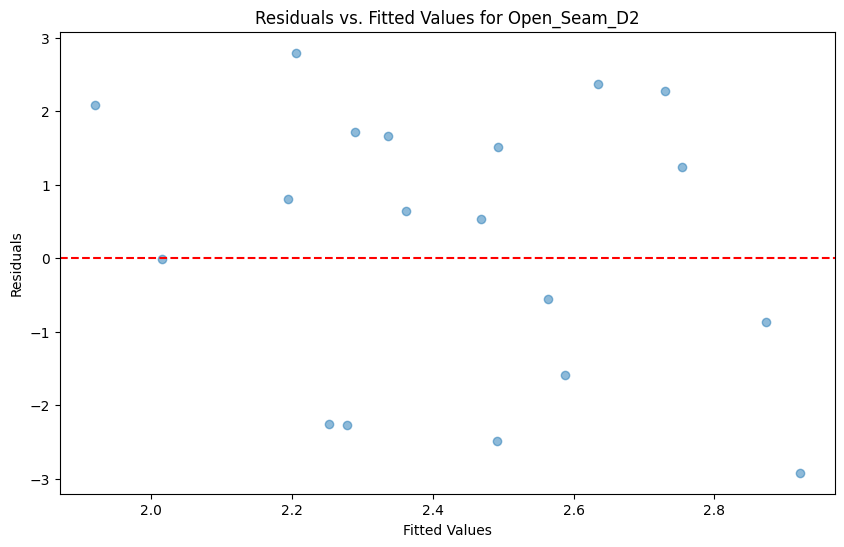

<Figure size 1000x600 with 0 Axes>

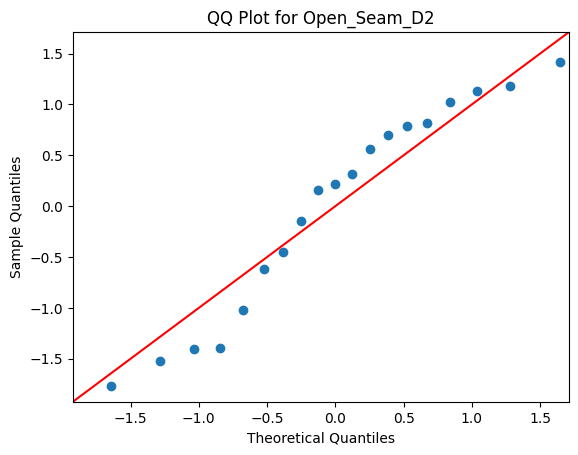

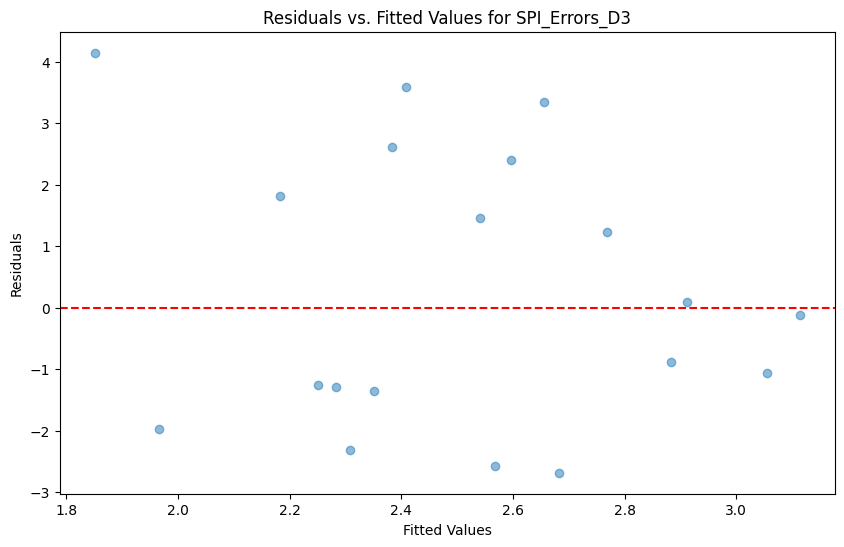

<Figure size 1000x600 with 0 Axes>

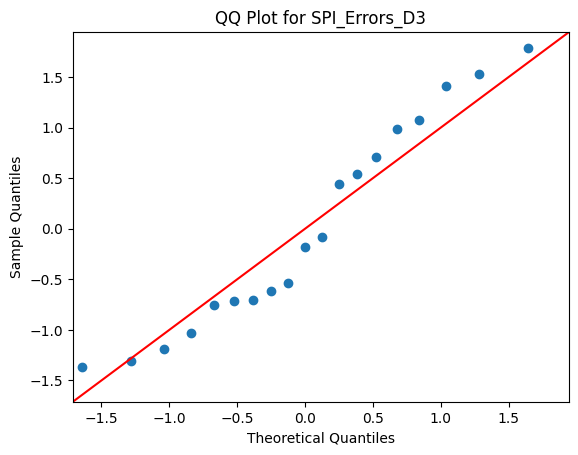

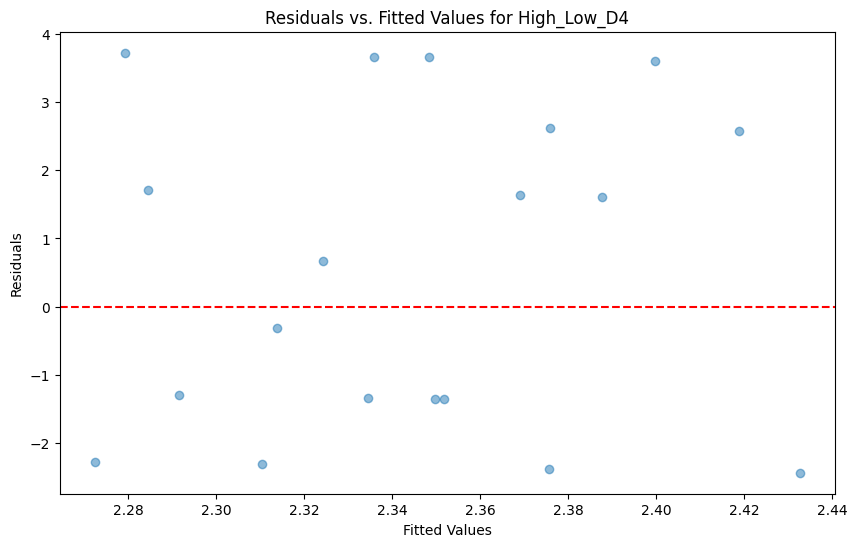

<Figure size 1000x600 with 0 Axes>

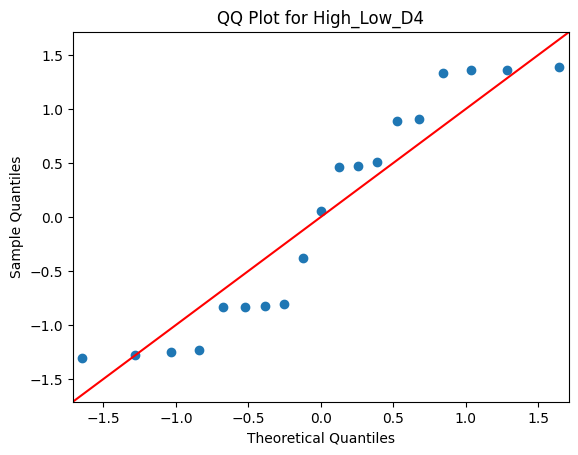

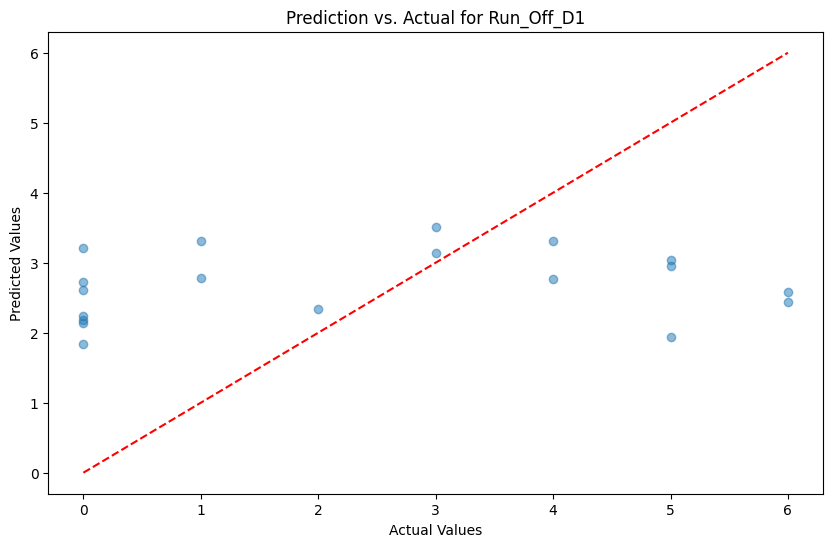

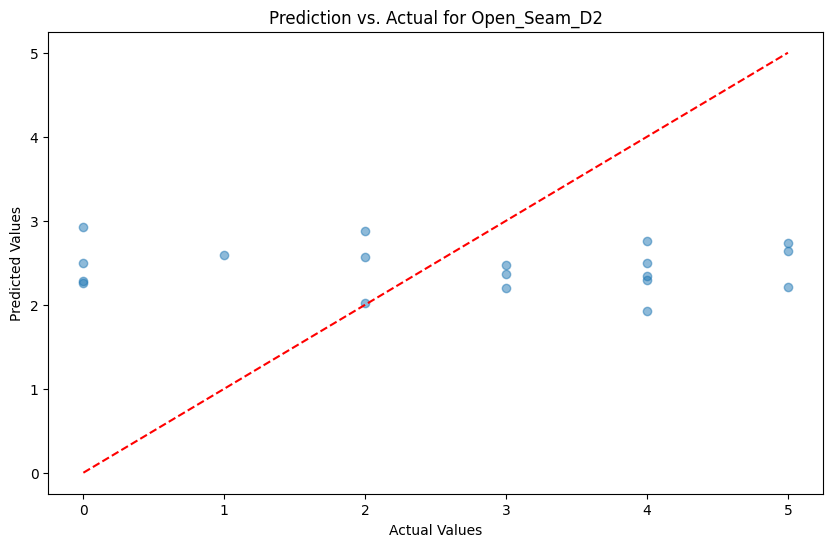

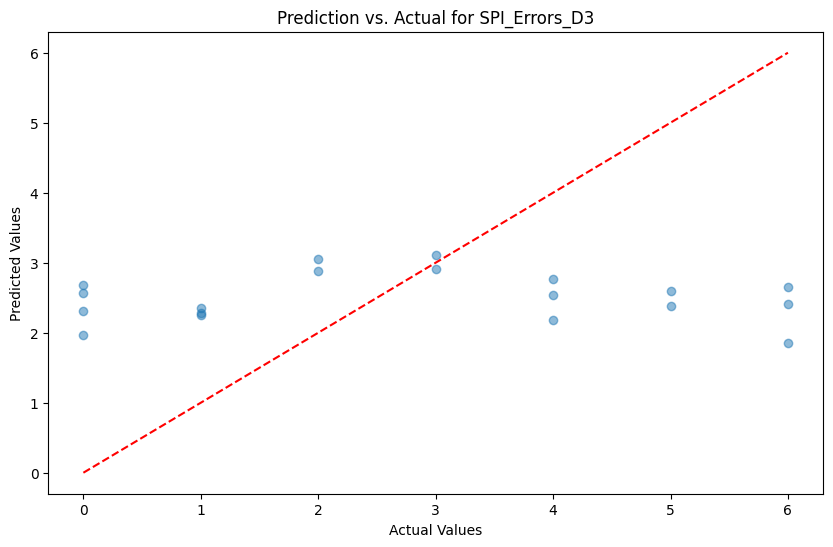

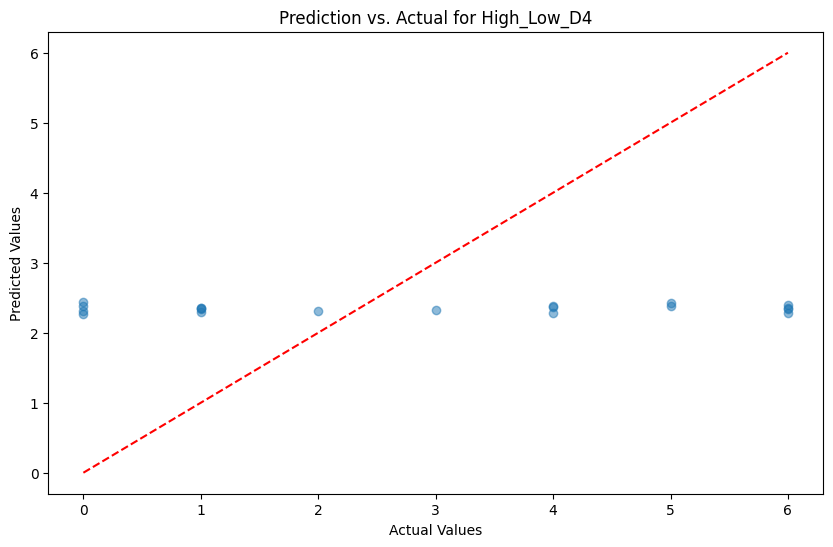

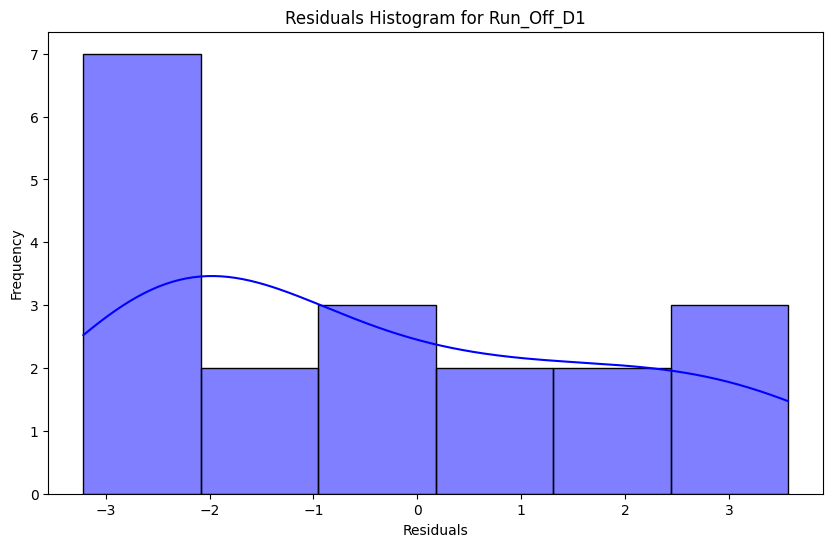

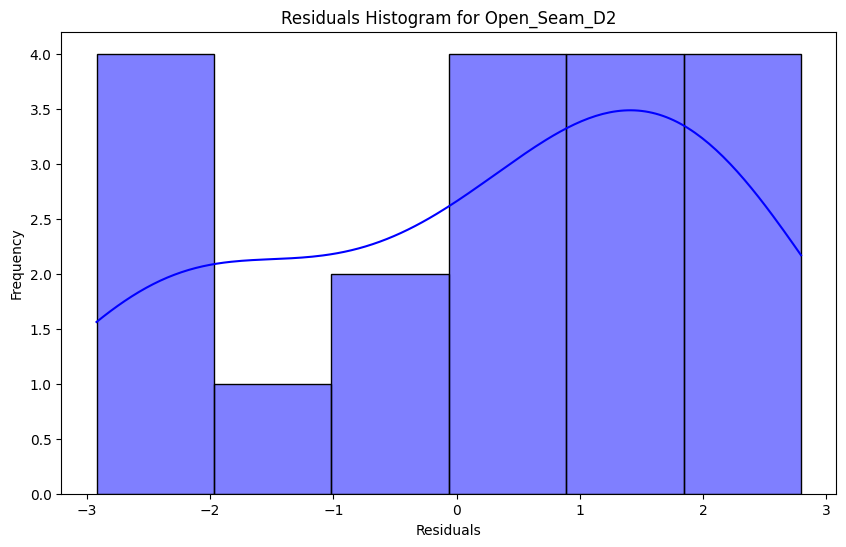

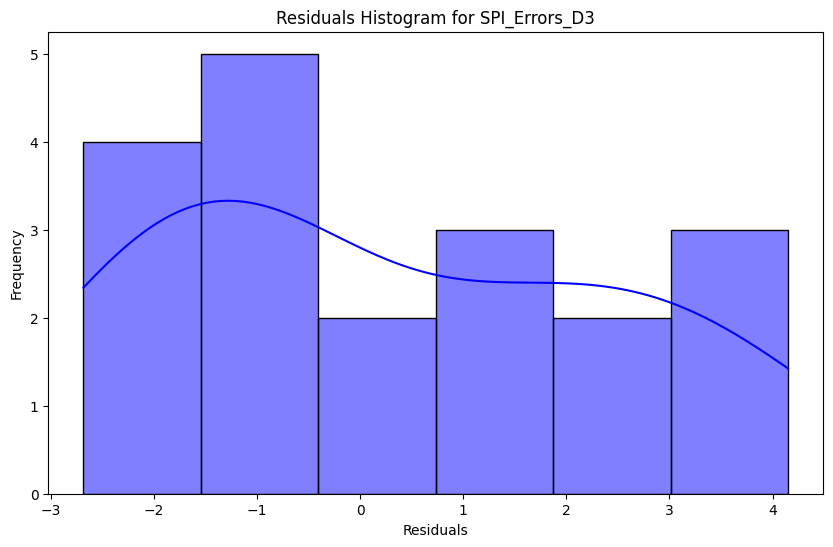

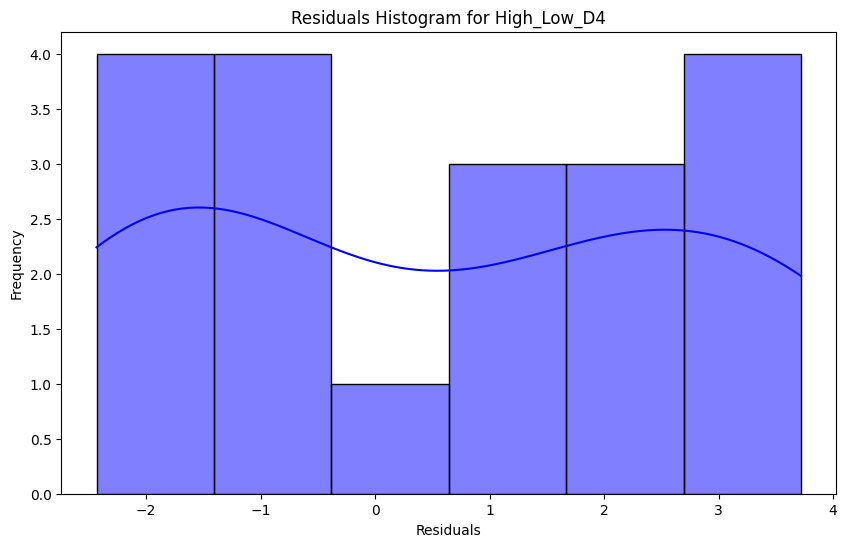

In [10]:
import statsmodels.api as sm

# Residuals vs. Fitted Values and QQ Plots
def plot_diagnostics(y_test, y_pred, defect_type):
    # Residuals vs. Fitted Values
    fitted_values = y_pred[:, y_test.columns.get_loc(defect_type)]
    residuals = y_test[defect_type] - fitted_values
    
    plt.figure(figsize=(10, 6))
    plt.scatter(fitted_values, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals vs. Fitted Values for {defect_type}')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.show()
    
    # QQ Plot for Residuals
    plt.figure(figsize=(10, 6))
    sm.qqplot(residuals, line='45', fit=True)
    plt.title(f'QQ Plot for {defect_type}')
    plt.show()

# Apply the diagnostics function to each defect type
for defect_type in y_test.columns:
    plot_diagnostics(y_test, y_pred, defect_type)

# Prediction vs. Actual Plot
for defect_type in defect_types:
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test[defect_type], y_pred[:, y_test.columns.get_loc(defect_type)], alpha=0.5)
    plt.plot([y_test[defect_type].min(), y_test[defect_type].max()], [y_test[defect_type].min(), y_test[defect_type].max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Prediction vs. Actual for {defect_type}')
    plt.show()

# Residuals Histogram
for defect_type in defect_types:
    residuals = y_test[defect_type] - y_pred[:, y_test.columns.get_loc(defect_type)]
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, color='blue')
    plt.title(f'Residuals Histogram for {defect_type}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

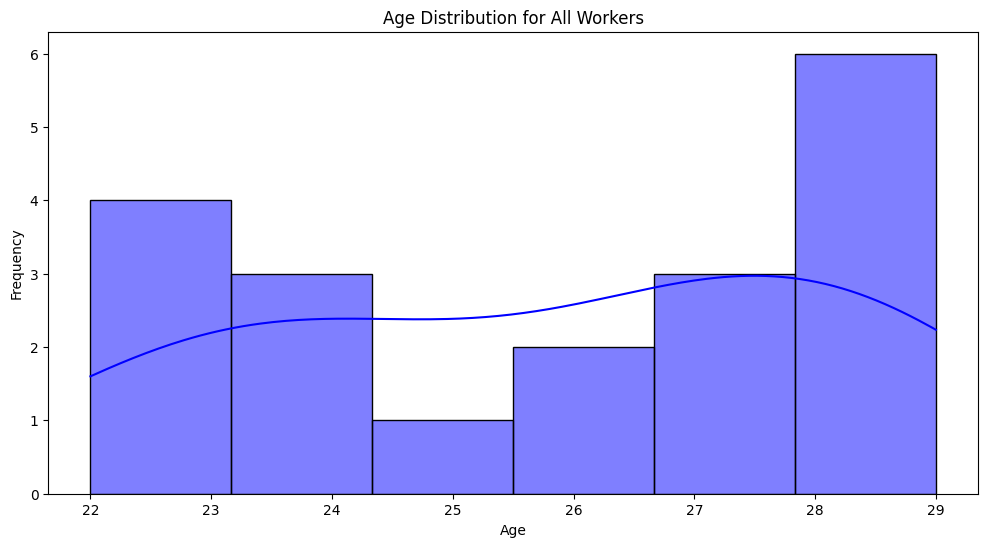

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/1735367613.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=demographic_data['Skill_Level'], palette='viridis')


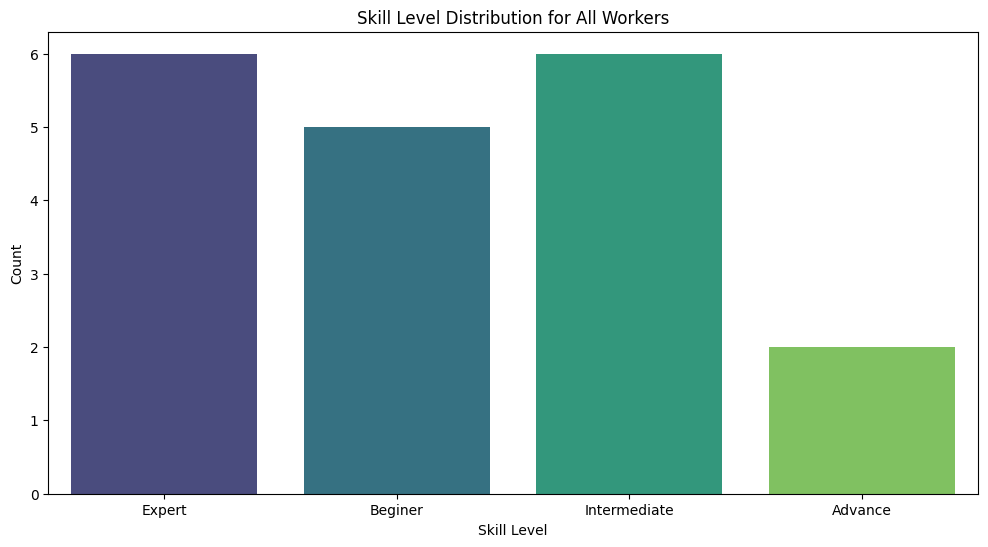

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_27547/1937286593.py:23: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_week_data = worker_data.last('7D')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/P

Worker Name: Sanuli Samaraweera
Last week's high defect type: Run_Off_D1 with count: 19
Last week's low defect type: SPI_Errors_D3 with count: 4

Future defect predictions for worker W_00001:
            Run_Off_D1  Open_Seam_D2  SPI_Errors_D3  High_Low_D4
2024-03-05    3.019314      2.739823       2.376819     2.300642
2024-03-06    2.931185      2.626286       2.313973     2.411580
2024-03-07    2.942215      2.635334       2.317583     2.432681
2024-03-08    2.940835      2.634613       2.317376     2.436694
2024-03-11    2.941008      2.634671       2.317388     2.437457


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.frame

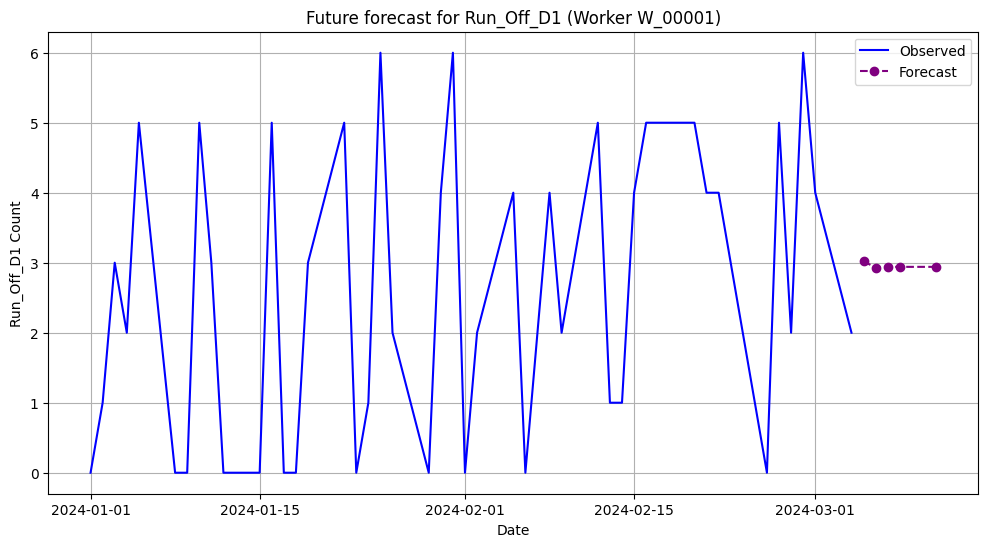

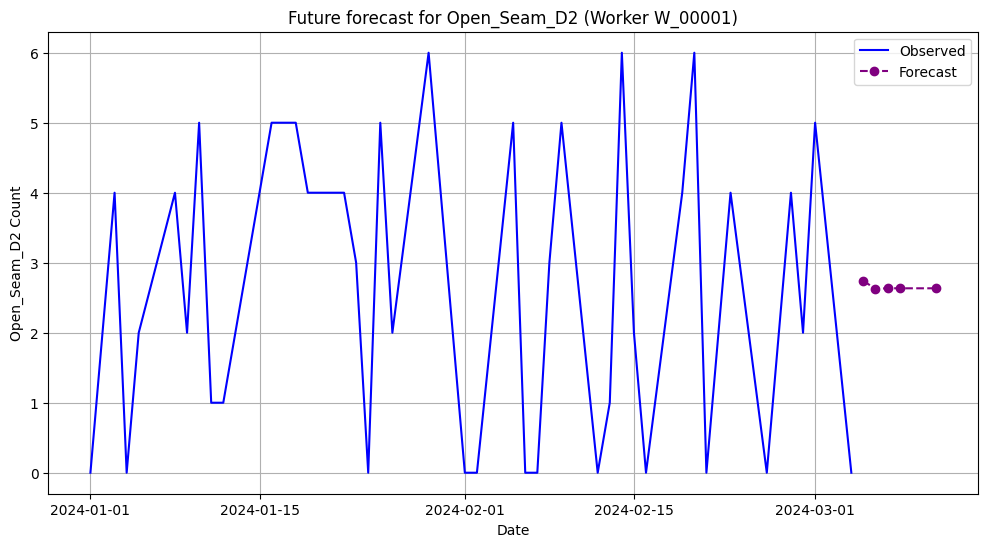

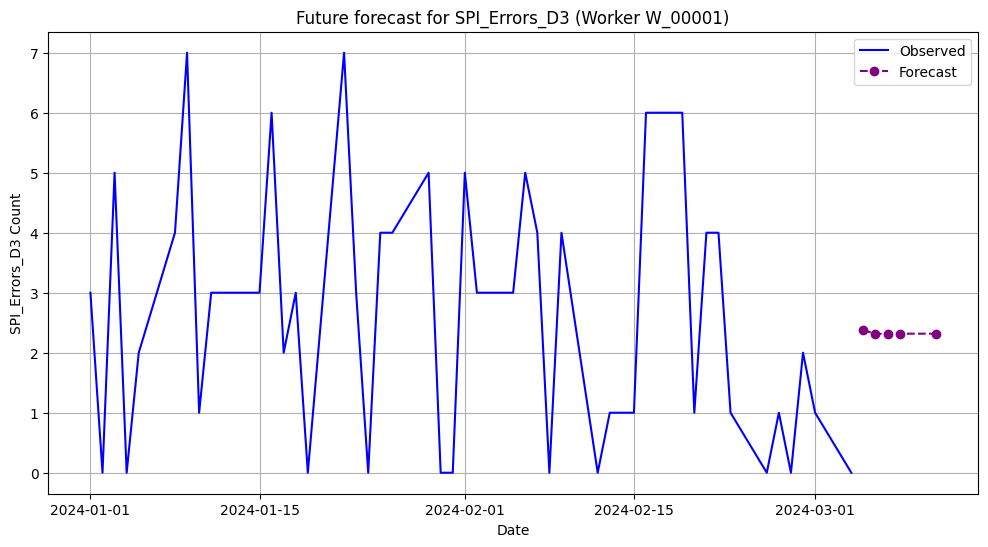

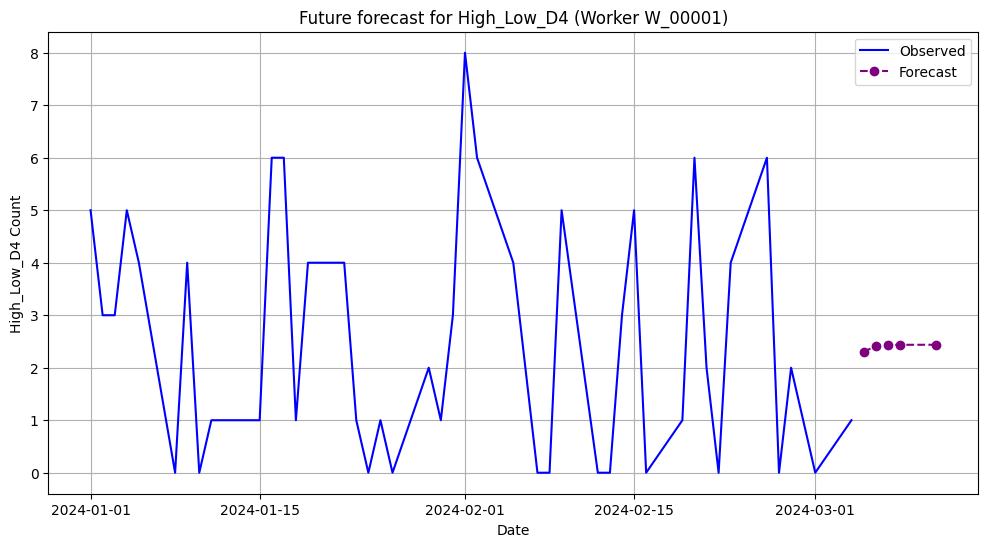

In [14]:
def train_arima_model(data, order=(1, 1, 1), steps=5):
    try:
        model = ARIMA(data, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=steps)
        return model_fit, forecast
    except Exception as e:
        print(f"An error occurred while training the ARIMA model: {e}")
        return None, np.full(steps, np.nan)

def analyze_worker(worker_id, forecast_steps=5):
    worker_data = combined_data[combined_data['Worker_ID'] == worker_id]
    worker_name = demographic_data.loc[demographic_data['Worker_ID'] == worker_id, 'Name'].values[0]

    if worker_data.empty:
        print(f"No data found for worker {worker_id}.")
        return

    # Ensure Date is set as index
    worker_data.set_index('Date', inplace=True)

    # Calculate last week's high and low defect types and their counts
    last_week_data = worker_data.last('7D')
    last_week_summary = last_week_data[['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4']].sum()
    last_week_high_defect_type = last_week_summary.idxmax()
    last_week_low_defect_type = last_week_summary.idxmin()
    last_week_high_defect_count = last_week_summary.max()
    last_week_low_defect_count = last_week_summary.min()

    # Print worker details
    print(f"Worker Name: {worker_name}")
    print(f"Last week's high defect type: {last_week_high_defect_type} with count: {last_week_high_defect_count}")
    print(f"Last week's low defect type: {last_week_low_defect_type} with count: {last_week_low_defect_count}")
    print()

    # Define categorical and numerical features
    categorical_features = ['Skill_Level']
    numerical_features = ['Age', 'Production_Volume']

    # Define preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(), categorical_features),
            ('num', StandardScaler(), numerical_features)
        ]
    )

    # Separate features and target variables for the worker
    X_worker = worker_data.drop(columns=['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4', 'defect_count', 'count', 'Worker_ID', 'Shift'])
    y_worker = worker_data[['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4']]

    # Train the best model on the worker data
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', best_model)
    ])
    pipeline.fit(X_worker, y_worker)

    # Prepare features for the specific worker for future predictions
    X_worker_future = pd.concat([X_worker.iloc[-1:].copy()] * forecast_steps, ignore_index=True)

    # Generate future predictions using the best traditional model
    y_pred_best_model = pipeline.predict(X_worker_future)

    # Generate ARIMA forecasts for each defect type
    arima_forecasts = {}
    for defect_type in ['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4']:
        model_fit, forecast = train_arima_model(worker_data[defect_type].dropna(), steps=forecast_steps)
        arima_forecasts[defect_type] = forecast

    # Combine traditional model predictions with ARIMA forecasts
    combined_predictions = {}
    for defect_type in ['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4']:
        combined_predictions[defect_type] = (y_pred_best_model[:, ['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4'].index(defect_type)] + arima_forecasts[defect_type]) / 2

    # Print future predictions
    future_dates = pd.date_range(start=worker_data.index[-1], periods=forecast_steps + 1, freq='B')[1:]
    future_predictions = pd.DataFrame(combined_predictions, index=future_dates)

    print(f"Future defect predictions for worker {worker_id}:")
    print(future_predictions)

    # Plotting the results
    for defect_type in ['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4']:
        plt.figure(figsize=(12, 6))
        plt.plot(worker_data.index, worker_data[defect_type], label='Observed', color='blue')
        plt.plot(future_dates, future_predictions[defect_type], label='Forecast', linestyle='--', marker='o', color='purple')
        plt.title(f'Future forecast for {defect_type} (Worker {worker_id})')
        plt.xlabel('Date')
        plt.ylabel(f'{defect_type} Count')
        plt.legend()
        plt.grid(True)
        plt.show()

# Perform demographic analysis for all workers
demographic_analysis_all()

# Prompt user to enter Worker ID for defect prediction
worker_id = input("Enter the Worker ID: ")
analyze_worker(worker_id, forecast_steps=5)